# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.creation import CyclicalFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

import numpy as np

In [2]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

In [3]:
print (df.index.min(), df.index.max())

2009-12-06 00:00:00 2011-12-11 00:00:00


<AxesSubplot:xlabel='week'>

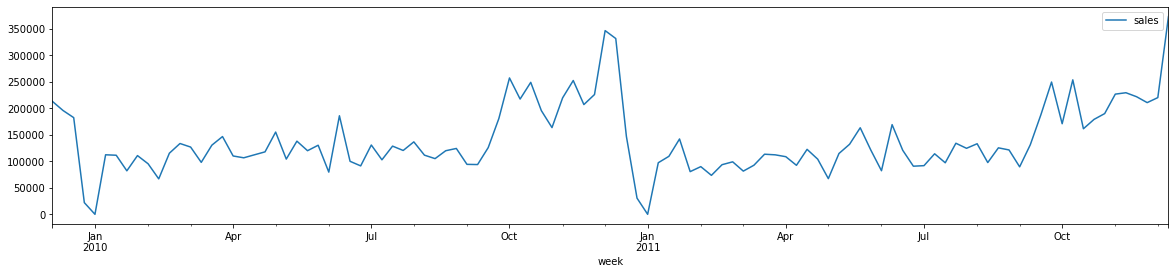

In [4]:
# Plot the time series
df.plot(figsize=(20, 4))


In [5]:
#looks like some weeks has 0 sales - probably due to holidahys
df.loc[(df.sales <= 0)]

,sales
week,
2010-01-03,0.0
2011-01-02,0.0


In [6]:
#removing these 0 sales#
df = df.loc[(df.sales > 0)]

<AxesSubplot:xlabel='week'>

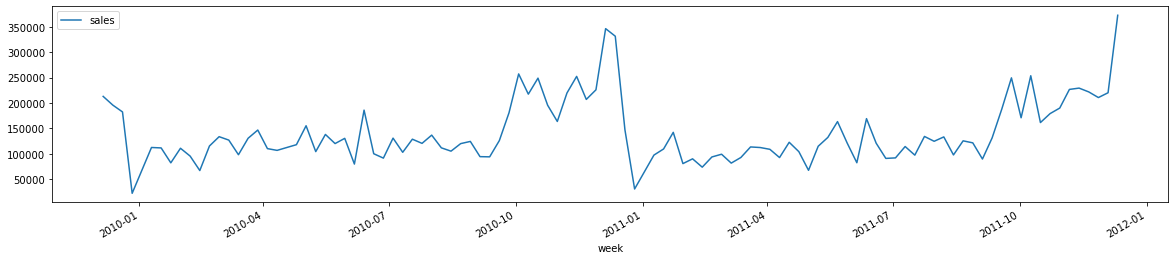

In [7]:
# Plot the time series
df.plot(figsize=(20, 4))


## Missing data

Check if there are missing values in the time series.

In [8]:
df.isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

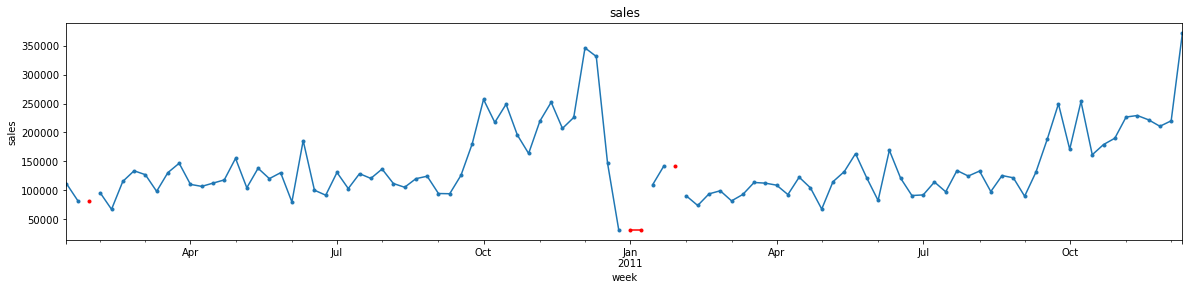

In [44]:
# Introduce the missing timestamps.
# Note that we capture this in a different dataframe.
data_ = df.asfreq("1W")

# Apply the forward fill method.
data_imputed = data_.fillna(method="ffill")

# plot the time series.
ax = data_["sales"].plot(linestyle="-", marker=".", figsize=[20, 4])

# plot the imputed values on top, in red.
data_imputed[data_.isnull()]["sales"].plot(ax=ax, legend=None, marker=".", color="r")

# Add title.
plt.title("sales")

# the y axis label
plt.ylabel("sales")

plt.show()

## Seasonality

Does the time series show any obvious seasonal pattern?

In [46]:
# Capture "time" in a new variable.

monthName_ = df.index.month

monthName_ = pd.Series(monthName_, index=df.index)

monthName_.head()

week
2010-01-17    1
2010-01-24    1
2010-02-07    2
2010-02-14    2
2010-02-21    2
Name: week, dtype: int32

Text(0, 0.5, 'sales')

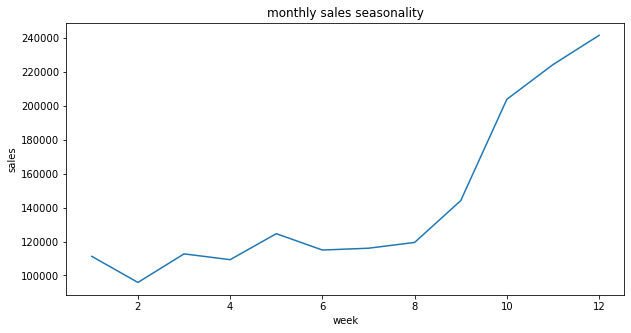

In [48]:
# Plot the average pollutant concentration per hour.
df.groupby(df.index.month)["sales"].mean().plot(figsize=(10, 5))
plt.title("monthly sales seasonality")
plt.ylabel("sales")

Text(0, 0.5, 'Sales')

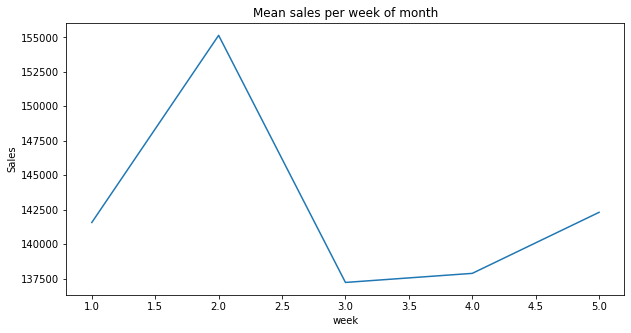

In [49]:
# Plot the average sales for every 1,2,3,4 and 5 week of a month.

wom = (df.index.day - 1) // 7 + 1

df.groupby(wom)["sales"].mean().plot(figsize=(10, 5))
plt.title("Mean sales per week of month")
plt.ylabel("Sales")

# Feature engineering

Now, let's begin to tabularize the data.

In [12]:
# Extract date and time features.

df["Month"] = df.index.month
df["Week"] = df.index.isocalendar().week
# Show new variables
df.head()

C:\Users\I554645\AppData\Local\Temp/ipykernel_23164/3156595349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Month"] = df.index.month
C:\Users\I554645\AppData\Local\Temp/ipykernel_23164/3156595349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Week"] = df.index.isocalendar().week


,sales,Month,Week
week,,,
2009-12-06,213000.35,12,49
2009-12-13,195810.04,12,50
2009-12-20,182396.74,12,51
2009-12-27,22007.77,12,52
2010-01-10,112318.85,1,1


In [13]:
# Here, I show how to move the variables forward by 1 hr,
# so that the pollutant concentration from the previous
# hour (t-1) is aligned with the current hour (t),
# which is the forecasting point.

# raw time series
variables = ["sales"]

# Shift the data forward 1 Hr.
tmp = df[variables].shift(freq="1W")

# Names for the new variables.
tmp.columns = [v + "_lag_1" for v in variables]

# Add the variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(104, 3)
data size after
(104, 4)


,sales,Month,Week,sales_lag_1
week,,,,
2009-12-06,213000.35,12,49,NaN
2009-12-13,195810.04,12,50,213000.35
2009-12-20,182396.74,12,51,195810.04
2009-12-27,22007.77,12,52,182396.74
2010-01-10,112318.85,1,1,NaN


In [14]:
df

,sales,Month,Week,sales_lag_1
week,,,,
2009-12-06,213000.35,12,49,NaN
2009-12-13,195810.04,12,50,213000.35
2009-12-20,182396.74,12,51,195810.04
2009-12-27,22007.77,12,52,182396.74
2010-01-10,112318.85,1,1,NaN
...,...,...,...,...
2011-11-13,229378.01,11,45,226770.53
2011-11-20,221870.29,11,46,229378.01
2011-11-27,210741.76,11,47,221870.29


In [15]:
df.isnull().sum()

sales          0
Month          0
Week           0
sales_lag_1    3
dtype: int64

In [16]:
# Now we repeat the exercise, but this time
# the values are moved forward 24 hours.

# Move forward 24 hrs.
tmp = df[variables].shift(freq="4W")

# Rename the variables.
tmp.columns = [v + "_lag_24" for v in variables]

# Add the features to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head(25)

data size before
(104, 4)
data size after
(104, 5)


,sales,Month,Week,sales_lag_1,sales_lag_24
week,,,,,
2009-12-06,213000.350,12,49,NaN,NaN
2009-12-13,195810.040,12,50,213000.350,NaN
2009-12-20,182396.740,12,51,195810.040,NaN
2009-12-27,22007.770,12,52,182396.740,NaN
2010-01-10,112318.850,1,1,NaN,195810.040
2010-01-17,111460.470,1,2,112318.850,182396.740
2010-01-24,82065.331,1,3,111460.470,22007.770
2010-01-31,110790.591,1,4,82065.331,NaN
2010-02-07,95340.552,2,5,110790.591,112318.850


In [17]:
df.isnull().sum()

sales           0
Month           0
Week            0
sales_lag_1     3
sales_lag_24    6
dtype: int64

In [18]:
# Use the mean of the 3 previous hours as input variables.

tmp = (
    df[variables]
    .rolling(window=3)
    .mean()  # Average the last 3 hr values.
    .shift(freq="1W")  # Move the average 1 hour forward
)

# Rename the columns
tmp.columns = [v + "_window" for v in variables]


# view of the result
tmp.head(10)

,sales_window
week,
2009-12-13,NaN
2009-12-20,NaN
2009-12-27,197069.043333
2010-01-03,133404.850000
2010-01-17,105574.453333
2010-01-24,81929.030000
2010-01-31,101948.217000
2010-02-07,101438.797333
2010-02-14,96065.491333


In [19]:
# Join the new variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(104, 5)
data size after
(104, 6)


,sales,Month,Week,sales_lag_1,sales_lag_24,sales_window
week,,,,,,
2009-12-06,213000.35,12,49,NaN,NaN,NaN
2009-12-13,195810.04,12,50,213000.35,NaN,NaN
2009-12-20,182396.74,12,51,195810.04,NaN,NaN
2009-12-27,22007.77,12,52,182396.74,NaN,197069.043333
2010-01-10,112318.85,1,1,NaN,195810.04,NaN


In [22]:
cyclical = CyclicalFeatures(
    variables=["Month", "Week"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

In [24]:
df.head()

,sales,Month,Week,sales_lag_1,sales_lag_24,sales_window,Month_sin,Month_cos,Week_sin,Week_cos
week,,,,,,,,,,
2009-12-06,213000.35,12,49,NaN,NaN,NaN,-2.449294e-16,1.000000,-0.354605,0.935016
2009-12-13,195810.04,12,50,213000.35,NaN,NaN,-2.449294e-16,1.000000,-0.239316,0.970942
2009-12-20,182396.74,12,51,195810.04,NaN,NaN,-2.449294e-16,1.000000,-0.120537,0.992709
2009-12-27,22007.77,12,52,182396.74,NaN,197069.043333,-2.449294e-16,1.000000,-0.0,1.0
2010-01-10,112318.85,1,1,NaN,195810.04,NaN,5.000000e-01,0.866025,0.120537,0.992709


In [25]:
df.isnull().sum() / len(df)

sales           0.000000
Month           0.000000
Week            0.000000
sales_lag_1     0.028846
sales_lag_24    0.057692
sales_window    0.048077
Month_sin       0.000000
Month_cos       0.000000
Week_sin        0.000000
Week_cos        0.000000
dtype: float64

In [26]:
print("data size before")
print(df.shape)

df.dropna(inplace=True)

print("data size after")
print(df.shape)

data size before
(104, 10)
data size after
(96, 10)


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [27]:
df.index.min(), df.index.max()

(Timestamp('2010-01-17 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [28]:
X_train = df[df.index <= "2011-08-01"]
X_test = df[df.index > "2011-08-01"]

X_train.shape, X_test.shape

((77, 10), (19, 10))

In [29]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

In [33]:
df

,sales,Month,Week,sales_lag_1,sales_lag_24,sales_window,Month_sin,Month_cos,Week_sin,Week_cos
week,,,,,,,,,,
2010-01-17,111460.470,1,2,112318.850,182396.740,105574.453333,5.000000e-01,0.866025,0.239316,0.970942
2010-01-24,82065.331,1,3,111460.470,22007.770,81929.030000,5.000000e-01,0.866025,0.354605,0.935016
2010-02-07,95340.552,2,5,110790.591,112318.850,101438.797333,8.660254e-01,0.500000,0.568065,0.822984
2010-02-14,66868.850,2,6,95340.552,111460.470,96065.491333,8.660254e-01,0.500000,0.663123,0.748511
2010-02-21,115261.842,2,7,66868.850,82065.331,90999.997667,8.660254e-01,0.500000,0.748511,0.663123
...,...,...,...,...,...,...,...,...,...,...
2011-11-13,229378.010,11,45,226770.530,161438.540,198636.933333,-5.000000e-01,0.866025,-0.748511,0.663123
2011-11-20,221870.290,11,46,229378.010,179106.070,215394.246667,-5.000000e-01,0.866025,-0.663123,0.748511
2011-11-27,210741.760,11,47,221870.290,190034.200,226006.276667,-5.000000e-01,0.866025,-0.568065,0.822984


## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [35]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  44319.33033834646
test rmse:  55645.392882097716


## Machine Learning

In [36]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [37]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  25112.698350310227
test rmse:  39976.78960784441


In [38]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

C:\Users\I554645\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e+10, tolerance: 2.348e+07
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=100, random_state=0)

In [39]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  35468.208683889454
test rmse:  48724.32173247361


Text(0, 0.5, 'Importance')

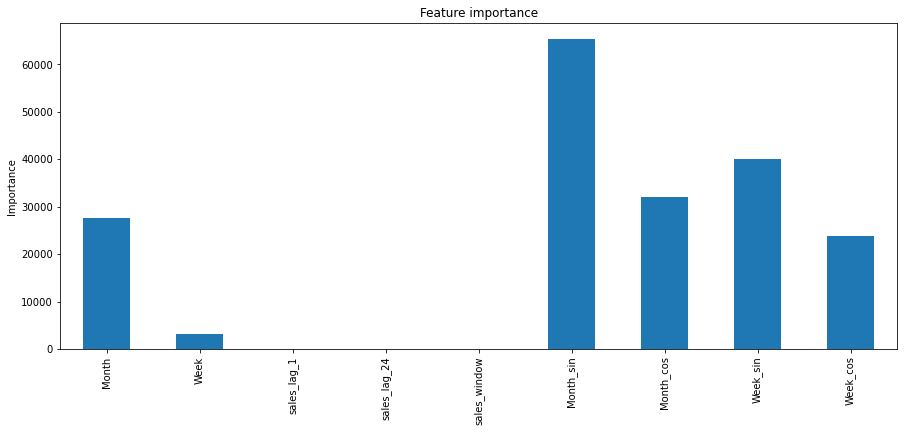

In [42]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")